In [33]:
import os
import sys
# Load the local code
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.read_parallel import read_parallel_local
import pandas as pd

In [34]:
#!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git /home/ubuntu/models
#! pip install tensorflow_hub
#! pip install tensorflow_datasets
#!pip install -Uqr /home/ubuntu/models/official/requirements.txt


In [35]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('/home/ubuntu/models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [36]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [43]:
REDUCE_BY_FACTOR = 5 # Make the dataset smaller for development purposes
train_test_ratio = 0.91
train_valid_ratio = 0.90
first_n_words = 512
destination_folder = 'bert_classification'

if 'DATA_VOL' not in os.environ:
    # Manually set:
    DATA_VOL = '/datavol'
else:
    DATA_VOL = os.environ['DATA_VOL']
    
# Pre-wrangled metadata
df = pd.read_csv("../references/derived/ml_data.csv", encoding="latin1", parse_dates=True)
df.id = df.id.astype(int)    
print(f"Original number of examples: {len(df)}")
df = df.sample(n=int(len(df)/REDUCE_BY_FACTOR)) #
print(f"Reduced number of examples:  {len(df)}")

tmp = read_parallel_local(df['id'], DATA_VOL + "/clean/")
df['text'] = tmp
df = df.reset_index(drop=True)

Original number of examples: 199646
Reduced number of examples:  39929
Took 0.10945926507314047 min to open 39929 files with 20 processes.


In [44]:
#import pandas as pd
#df = pd.read_csv("../references/derived/ml_data.csv", encoding="latin1", parse_dates=True)
df.tail()

,id,version_number,bill_id,signed,partisan_lean,sc_id,text
39924,2415668,2,1206674,0,0.647030,520-1,"senate, no. state of new jersey 218th legisla..."
39925,2549893,1,1307596,0,0.626372,605-2,101st general assembly state of illinois and h...
39926,2638383,1,1336312,0,0.738123,592-1,new york state assembly speaker carl e. heast...
39927,2330858,2,1216747,0,0.738123,592-1,state of new york regular sessions in senate ...
39928,2476867,1,1263209,1,0.525000,626-2,2020 session | | | print version 20103509d hou...


In [45]:
def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x
    
for i in range(len(df)):
    df.at[i, 'text'] = trim_string(df.at[i, 'text'])

In [46]:
# Train-test split
df_train_full, df_test = train_test_split(df, train_size = train_test_ratio, random_state = 1, stratify = df.signed.values)
# Train-valid split
df_train, df_valid = train_test_split(df_train_full, train_size = train_valid_ratio, random_state = 1, stratify = df_train_full.signed.values)

In [47]:
print(f"Training size: {df_train.shape}")
print(f"Validation size: {df_valid.shape}")
print(f"Test size: {df_test.shape}")

Training size: (32701, 7)
Validation size: (3634, 7)
Test size: (3594, 7)


In [48]:
!nvidia-smi

Sun Feb 28 23:28:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   45C    P0    70W / 149W |  11216MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [49]:
import tensorflow as tf
print(tf.version.VERSION)

2.4.1


In [50]:
#!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

In [51]:
#!pip install -Uqr models/official/requirements.txt
#f.device()

In [52]:
train_data1 = tf.data.Dataset.from_tensor_slices((df_train['text'].values, df_train['signed'].values, df_train['partisan_lean'].values))
val_data1 = tf.data.Dataset.from_tensor_slices((df_valid['text'].values, df_valid['signed'].values, df_valid['partisan_lean'].values))
test_data1 = tf.data.Dataset.from_tensor_slices((df_test['text'].values, df_test['signed'].values, df_test['partisan_lean'].values))

In [53]:
for text, label, pl in train_data1.take(1):
    print(text)
    print(label)
    print(pl)

tf.Tensor(b'no full text available for s1795-2019', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0.7381234334701587, shape=(), dtype=float64)


In [54]:
train_batch_size = 16
max_seq_length = 128  # Your choice here.

In [55]:
!nvidia-smi
#!sudo kill -9 3649

Sun Feb 28 23:29:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   45C    P0    70W / 149W |  11216MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [56]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
label_list = [0,1]

In [57]:
def to_feature(text, label, partisan_lean, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  
    example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
    
    feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id, 
            partisan_lean)



In [58]:
def to_feature_map(text, label, partisan_lean):
    input_ids, input_mask, segment_ids, label_id, partisan_lean  \
       = tf.py_function(to_feature, [text, label, partisan_lean], Tout = [tf.int32, tf.int32, tf.int32, tf.int32, tf.float64])
    
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])
    partisan_lean.set_shape([])
    
    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids,
        'partisan_lean': partisan_lean
    }
    
    return (x, label_id)
    
    

In [59]:
with tf.device('/cpu:0'):
    train_data = (train_data1.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
             
             .shuffle(1000)
             .batch(train_batch_size, drop_remainder=True)
             .prefetch(tf.data.experimental.AUTOTUNE) 
             )

    val_data = (val_data1.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
             .batch(train_batch_size, drop_remainder=True)
             .prefetch(tf.data.experimental.AUTOTUNE) 
            )

In [60]:
val_data.element_spec

({'input_word_ids': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None),
  'partisan_lean': TensorSpec(shape=(16,), dtype=tf.float64, name=None)},
 TensorSpec(shape=(16,), dtype=tf.int32, name=None))

In [61]:
def create_model_1():
    
        input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
        input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
        input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")
        partisan_lean = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name="partisan_lean")
        
        pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
        drop = tf.keras.layers.Dropout(0.4)(pooled_output)
        

        concat = tf.keras.layers.concatenate([drop, partisan_lean], axis=1)
        
        output = tf.keras.layers.Dense(1, activation='sigmoid')(concat)
        
        model = tf.keras.Model(
          inputs={
              'input_word_ids': input_word_ids,
              'input_mask': input_mask,
              'input_type_ids': input_type_ids,
              'partisan_lean': partisan_lean
          },
          outputs=output
        )
        return model

In [62]:
model = create_model_1()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [63]:
#import pydot
#tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [ ]:
epochs = 4
history = model.fit(train_data,
                   validation_data=val_data,
                   epochs=epochs,
                   verbose=1)

Epoch 1/4
1924/2043 [===========================>..] - ETA: 1:40 - loss: 0.3476 - binary_accuracy: 0.8706

In [28]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

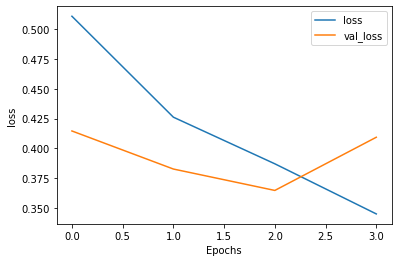

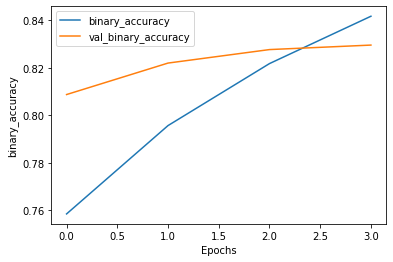

In [29]:
plot_graphs(history, 'loss')
plot_graphs(history, 'binary_accuracy')

In [30]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [31]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [32]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]